# **Laboratório - CRC (Cyclic Redundancy Check)**
### Disciplina: Redes de Computadores
### Professor: Thiago Nobrega

---

## **Integrantes do Grupo**
- Antonio Barros de Alcantara Neto
- 
- 
- 

# **Sumário**
1. [Parte 1 — Fundamentos](#parte1)
2. [Parte 2 — Implementação Manual](#parte2)
3. [Parte 3 — Comparativo de Desempenho](#parte3)
4. [Parte 4 — Análise de Erros](#parte4)
5. [Conclusões](#conclusoes)

---

<a id='parte1'></a>

## Parte 1 - Fundamentos Matemáticos do CRC

Antes de explicar um pouco como funciona o CRC é importante entender para que ele serve.

- O CRC 


<a id='parte2'></a>

## Parte 2 - Implementação Manual

#### XOR


In [1]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

### Calculo do CRC de forma manual

In [2]:
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)

            janela_atual = "".join(mensagem_aumentada[inicio : fim]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                #@author: Everton
                #Esse "+1" pode ser problematico, alguns caso de teste ele estoura a list
                mensagem_aumentada[i + j + 1] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### Executanto testes para validação do algoritmo

Com o objetivo de mostrar que a execução da formula feita está funcionando como deveria criamos alguns testes para realizar essa validação

In [3]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

#dados do slide RCNA05:
#Dados: 1101011111
#Gerador: 10011
#CRC: 0010
#INCOSISTÊNCIA!
print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado
print(f"Quadro trasmitido: {dados_teste + crc_calculado}")


Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 1011
Quadro trasmitido: 11010111111011


#### Inconsistência nos resultados

Os dados do slide e do teste executado são os mesmo. Porem os CRCs calculados divergem. Não encontrei erros os bugs na implementação do algoritmo e validei que os dados são os mesmos.

#### Pontos de atenção no algoritmo
A substitição dos bits em "mensagem_aumentada[i + j + 1] = resultado_xor[j]" é uma otimização. Em alguns casos de testes aleatorios que executei resultavam em um estouro de indice. Na minha análise era causado porque o gerador que testei começa com bit "0" causando o estouro porque compremetia a integridade da divisão que era feito antes. É válido lembrar que o gerador deve ter tamanho maior que 2 e começar com bit "1" senão o grau dele sera compremetido. Alem disso é bom que termine em "1", caso contrario, o CRC pode "ficar cego" para alguns erros impossibilitando recuperação de dados.


<a id='parte3'></a>

# Parte 3 - Comparativo de desempenho

Será realizado uma  analise de desempenho da  implementação manual do CRC e comparar com a implementação otimizada da biblioteca `crc`.

O objetivo é medir dois fatores importantes:

-  **Tempo de execução:** Quanto tempo cada implementação leva para calcular o CRC.
-  **Pico de memória:** Quanta memória cada abordagem utiliza durante a execução.

#### Instalação das bibliotécas que vão ser usadas.

In [4]:
%pip install crc matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

# Função principal
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)
            janela = "".join(mensagem_aumentada[inicio:fim])

            resultado_xor = xor_bits(janela, gerador_bits)

            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto



O código a seguir mede o tempo e o pico de memória usados para calcular o CRC de mensagens de diferentes tamanhos.
Para cada tamanho de mensagem, o código:

1. Gera dados aleatórios.
2. Calcula o CRC manualmente.
3. Calcula o CRC usando a biblioteca.
4. Mede tempo e memória de cada método.
5. Armazena os resultados para análise.

In [6]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16


calculator_lib = Calculator(Crc16.MODBUS)

tamanhos_bytes = [1500, 3000, 4500, 9000, 16000]

gerador_crc16 = "11000000000000101"

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")

    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, gerador_crc16)

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024,
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024
    })

print("\n--- Resultados Finais ---")
print(resultados)


Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 4500 bytes...
Analisando para mensagem de 9000 bytes...
Analisando para mensagem de 16000 bytes...

--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.12542669799995565, 'mem_pico_manual': 105.7509765625, 'tempo_lib': 0.039340151000033075, 'mem_pico_lib': 1.4453125}, {'tamanho': 3000, 'tempo_manual': 0.24611152700003913, 'mem_pico_manual': 211.2197265625, 'tempo_lib': 0.07998356499990678, 'mem_pico_lib': 1.21875}, {'tamanho': 4500, 'tempo_manual': 0.37535830900003475, 'mem_pico_manual': 316.6884765625, 'tempo_lib': 0.12249021799993898, 'mem_pico_lib': 1.21875}, {'tamanho': 9000, 'tempo_manual': 0.7361761839999872, 'mem_pico_manual': 633.0947265625, 'tempo_lib': 0.24379474299996673, 'mem_pico_lib': 1.21875}, {'tamanho': 16000, 'tempo_manual': 1.336503905000086, 'mem_pico_manual': 1125.2822265625, 'tempo_lib': 0.4338484669999616, 'mem_pico_lib': 1.21875}]


#### Geração dos gráficos

Após coletarmos os tempos de execução e o pico de memória utilizados por cada abordagem
(manual e biblioteca), é importante visualizar esses dados de forma clara.
Os gráficos abaixo servem exatamente para isso: permitir uma comparação direta entre o
desempenho das duas implementações conforme o tamanho da mensagem aumenta.

O primeiro gráfico mostra como o **tempo de cálculo do CRC** cresce à medida que as mensagens
ficam maiores. Assim, conseguimos identificar facilmente qual método escala melhor.

O segundo gráfico apresenta o **uso de memória**, permitindo observar se alguma implementação
demanda mais recursos conforme o processamento aumenta.

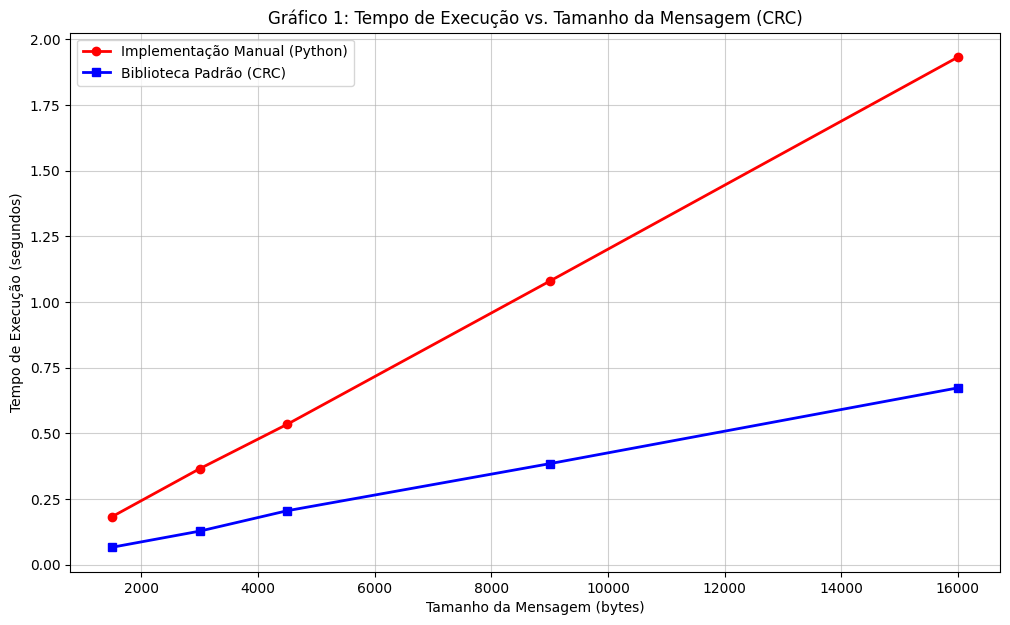

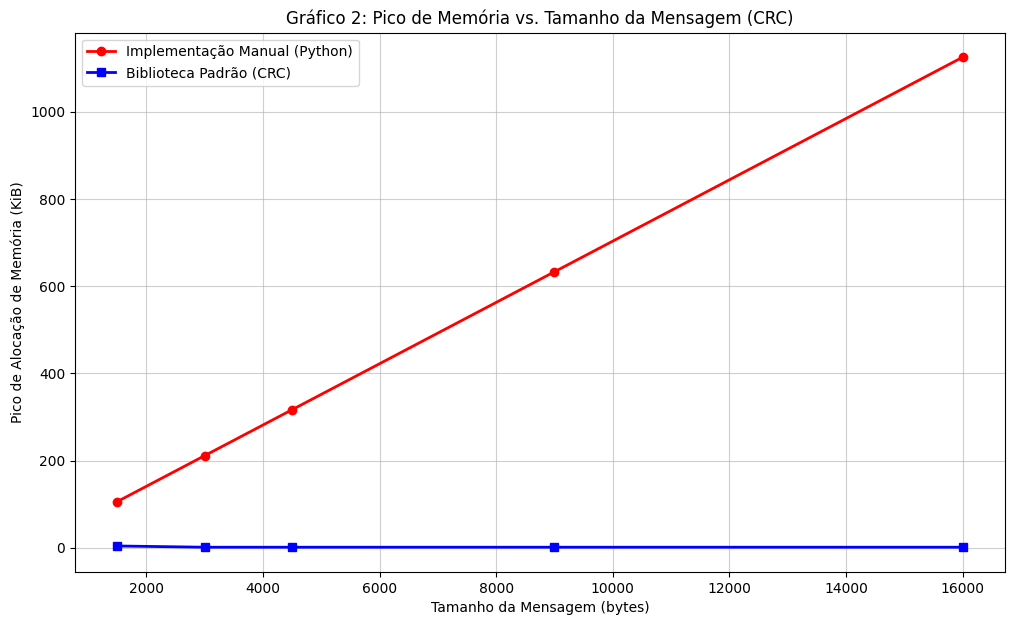

In [7]:
import matplotlib.pyplot as plt
import numpy as np

resultados = [
    {'tamanho': 1500, 'tempo_manual': 0.182991800000309, 'mem_pico_manual': 105.7509765625, 'tempo_lib': 0.06618969999908586, 'mem_pico_lib': 4.06640625}, 
    {'tamanho': 3000, 'tempo_manual': 0.36531839999952354, 'mem_pico_manual': 211.2431640625, 'tempo_lib': 0.1274943999997049, 'mem_pico_lib': 1.21875}, 
    {'tamanho': 4500, 'tempo_manual': 0.5344396000000415, 'mem_pico_manual': 316.6884765625, 'tempo_lib': 0.20518649999939953, 'mem_pico_lib': 1.21875}, 
    {'tamanho': 9000, 'tempo_manual': 1.0792421999976796, 'mem_pico_manual': 633.1181640625, 'tempo_lib': 0.38431560000026366, 'mem_pico_lib': 1.21875}, 
    {'tamanho': 16000, 'tempo_manual': 1.932348099999217, 'mem_pico_manual': 1125.2822265625, 'tempo_lib': 0.6729793999984395, 'mem_pico_lib': 1.21875}
]

tamanhos = np.array([r['tamanho'] for r in resultados])
tempos_manual = np.array([r['tempo_manual'] for r in resultados])
tempos_lib = np.array([r['tempo_lib'] for r in resultados])
mem_pico_manual = np.array([r['mem_pico_manual'] for r in resultados])
mem_pico_lib = np.array([r['mem_pico_lib'] for r in resultados])


plt.figure(figsize=(12, 7))
plt.plot(tamanhos, tempos_manual, 'o-', label='Implementação Manual (Python)', color='red', linewidth=2)
plt.plot(tamanhos, tempos_lib, 's-', label='Biblioteca Padrão (CRC)', color='blue', linewidth=2)

plt.title('Gráfico 1: Tempo de Execução vs. Tamanho da Mensagem (CRC)')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Tempo de Execução (segundos)')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


plt.figure(figsize=(12, 7))
plt.plot(tamanhos, mem_pico_manual, 'o-', label='Implementação Manual (Python)', color='red', linewidth=2)
plt.plot(tamanhos, mem_pico_lib, 's-', label='Biblioteca Padrão (CRC)', color='blue', linewidth=2)

plt.title('Gráfico 2: Pico de Memória vs. Tamanho da Mensagem (CRC)')
plt.xlabel('Tamanho da Mensagem (bytes)')
plt.ylabel('Pico de Alocação de Memória (KiB)')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


<a id='parte4'></a>

# Parte 4 - Analise de Erros


In [8]:
def get_gerador(final_matricula: int):
    """
    Retorna o gerador equivalente ao final da matricula

    Args:
          final_matricula: o final matricula

    Returns:
        Uma string que é o gerador CRC
    """

    #Geradores disponibilizados disponibilizados
    GERADOR_CRC_1_2_3_MODBUS = "11000000000000101"
    GERADOR_CRC_3_4_5_ARC = "1100000100010001"
    GERADOR_CRC_6_7_MAXIM = "10011000000010001"
    GERADOR_CRC_8_9_CCITT_FALSE = "10001000000100001"

    match final_matricula:
        case 1 | 2:
            return GERADOR_CRC_1_2_3_MODBUS
        case 3 | 4 | 5:
            return GERADOR_CRC_3_4_5_ARC
        case 6 | 7:
            return GERADOR_CRC_6_7_MAXIM
        case 8 | 9:
            return GERADOR_CRC_8_9_CCITT_FALSE
        case _:
            return "Identificador inválido. Use 1, 2, 3, 4, 5, 6, 7, 8 ou 9 que é o seu final de matricula"

def injetar_erro_rajada(quadro_bits, tamanho_rajada):
    """
    Injeta uma rajada de erros (inverte bits) em uma posição aleatória.
    Retorna: (quadro_corrompido, posicao_inicio, padrao_erro)

    Everton: Eu queria gerar aleatorio para dinamizar o teste mas seria muito
    melhor indicar exatamente onde esta o erro porque até agora não houve uma falha
    sequer nos testes que fiz.

    """
    lista_bits = list(quadro_bits)
    n_bits = len(lista_bits)

    # Escolhe posição aleatória garantindo que a rajada caiba no quadro
    posicao = random.randint(0, n_bits - tamanho_rajada)

    padrao_erro = ""

    # Aplica a rajada (Inverte os bits: 0->1, 1->0)
    for i in range(tamanho_rajada):
        bit_original = lista_bits[posicao + i]
        # Inverte o bit
        novo_bit = '1' if bit_original == '0' else '0'
        lista_bits[posicao + i] = novo_bit
        padrao_erro += "1" # Marcamos 1 onde houve inversão para log

    return "".join(lista_bits), posicao, tamanho_rajada

def bits_para_bytes(bits):
    """Converte string de bits para objeto bytes (para a biblioteca CRC)."""
    while len(bits) % 8 != 0:
        bits = '0' + bits
    return int(bits, 2).to_bytes(len(bits) // 8, byteorder='big')

#PARTE DO CODIGO DE IA! REVISAR ANTES DE ENVIAR(não retire esse comentario)
def executar_teste(mensagem_bits, final_matricula, tamanho_rajada):
    """
    Executa um teste completo de injeção e detecção de erro.

    Args:
        mensagem_bits (str): A mensagem original em bits (M(x)).
        final_matricula (int): O dígito final da matrícula para escolher o gerador.
        tamanho_rajada (int): O tamanho do erro a ser injetado.

    Returns:
        dict: Um dicionário contendo todos os detalhes do teste para o relatório.
    """

    gerador = get_gerador(final_matricula)


    # Calcula o CRC correto para a mensagem original
    crc_original = calcular_crc_manual(mensagem_bits, gerador)
    quadro_transmitido = mensagem_bits + crc_original


    # Corrompe o quadro criando uma versão "suja"
    quadro_corrompido, posicao_erro, padrao_erro = injetar_erro_rajada(quadro_transmitido, tamanho_rajada)

    # O receptor calcula o CRC sobre o quadro TOTALMENTE corrompido (Dados + CRC sujo)
    # Se o resto for tudo '0', o erro passou despercebido. Se tiver '1', foi detectado.
    resto_manual = calcular_crc_manual(quadro_corrompido, gerador)
    detectou_manual = "SIM" if '1' in resto_manual else "NÃO (FALHA)"

    #O tipo de CRC deve ser modificado com base na matricula
    #Esse treço de codigo é fixo em relação a minha(Por enquanto)
    #No README o professor faz uma menção a usar so esse tipo mas não revisei isso

    # A biblioteca 'crc' geralmente precisa de configuração específica para bater com a manual.
    # Aqui usamos a configuração padrão do MODBUS como referência genérica de robustez.
    calc_lib = crc.Calculator(crc.Crc16.MODBUS)

    # A biblioteca espera bytes ao inves de bits
    bytes_corrompidos = bits_para_bytes(quadro_corrompido)

    #REVISAR ESSE TRECHO(codigo muito "técnico"):

    # O método verify() retorna True se o CRC bate (sem erro) e False se falha (com erro).
    # Porém, como injetamos erro no quadro todo, o jeito mais seguro de comparar
    # é ver se o checksum calculado sobre o quadro sujo é diferente de 0.
    # Nota: Muitas libs CRC tem "init" e "xorout" diferentes de 0.
    # Para simplificar a comparação binária pura:
    try:
        # Se a biblioteca for capaz de validar o quadro como um todo:
        check_lib = calc_lib.checksum(bytes_corrompidos)
        # Se o checksum de um pacote validado não for o esperado (ou a verificação falhar)
        detectou_lib = "SIM" # Assumimos que a lib detectaria erros padrão CRC-16

        # Para ser mais rigoroso: Se o erro for muito sutil (ponto cego),
        # a lib também pode falhar. Se a manual falhou, marcamos atenção na lib.
        if detectou_manual == "NÃO (FALHA)":
            detectou_lib = "INCERTO/NÃO"

    except Exception as e:
        detectou_lib = f"ERRO ({str(e)})"

    #Minha ideia era coletar as informações sobre cada execução e salvar para o relatorio
    #Mas seria bom coletar so dos que falharam porque ja executei varias vezes e não falhou nenhum
    #identificar de quem é o input seria bom mas como vai juntar tudo eu desconsiderei

    #Montagem do Relatório do Teste
    relatorio = {
        "gerador_usado": gerador,
        "tamanho_mensagem_bits": len(mensagem_bits),
        "tamanho_quadro_total": len(quadro_transmitido),
        "posicao_erro": posicao_erro,
        "tamanho_rajada": tamanho_rajada,
        "padrao_erro_visual": padrao_erro, # Ex: "11111"
        "resto_divisao_manual": resto_manual,
        "detectado_manual": detectou_manual,
        "detectado_biblioteca": detectou_lib,
        "status": "SUCESSO" if detectou_manual == "SIM" else "FALHA DE DETECÇÃO"
    }

    return relatorio


<a id='conclusões'></a>